Importing libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, timedelta

def week_year_to_date(year, week):
    starting_date = datetime(int(year), 1, 1)
    return starting_date + timedelta(int(week)*7-7)

Loading Data

In [23]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Adding Features

In [24]:
df_grouped = df.groupby(['longitude', 'latitude'])
lst = []
for name, group_df in df_grouped:
    group_df['rolling_emission3'] = group_df['emission'].rolling(window = 3, center = True).mean()
    group_df['rolling_emission5'] = group_df['emission'].rolling(window = 5, center = True).mean()
    group_df['rolling_emission7'] = group_df['emission'].rolling(window = 7, center = True).mean()
    group_df['rolling_emission9'] = group_df['emission'].rolling(window = 9, center = True).mean()
    group_df['rolling_SulphurDioxide_SO2_column_number_density'] = group_df['SulphurDioxide_SO2_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['rolling_CarbonMonoxide_CO_column_number_density'] = group_df['CarbonMonoxide_CO_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['rolling_NitrogenDioxide_tropospheric_NO2_column_number_density'] = group_df['NitrogenDioxide_tropospheric_NO2_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['rolling_Formaldehyde_tropospheric_HCHO_column_number_density'] = group_df['Formaldehyde_tropospheric_HCHO_column_number_density'].rolling(window = 3, center = True).mean()
    group_df['week_lag_emission'] = group_df['emission'].shift(1)
    group_df['week_future_lag_emission'] = group_df['emission'].shift(-1)
    group_df = group_df.interpolate(method='linear', limit_direction='both')
    lst.append(group_df)
df = pd.concat(lst)

last_year_df = (df
                .assign(year=df['year'] + 1)
                .loc[:, ['year'
                         , 'week_no'
                         , 'longitude'
                         , 'latitude'
                         , 'emission'
                         , 'rolling_emission3'
                         , 'rolling_emission5'
                         , 'rolling_emission7'
                         , 'rolling_emission9'
                         , 'rolling_SulphurDioxide_SO2_column_number_density'
                         , 'rolling_CarbonMonoxide_CO_column_number_density'
                         , 'rolling_NitrogenDioxide_tropospheric_NO2_column_number_density'
                         , 'rolling_Formaldehyde_tropospheric_HCHO_column_number_density']]
                .rename(columns={'emission': 'last_year_emission'
                                 , 'rolling_emission3': 'ly_rolling_emission3'
                                 , 'rolling_emission5': 'ly_rolling_emission5'
                                 , 'rolling_emission7': 'ly_rolling_emission7'
                                 , 'rolling_emission9': 'ly_rolling_emission9'
                                 , 'rolling_SulphurDioxide_SO2_column_number_density' : 'ly_rolling_SulphurDioxide_SO2_column_number_density'
                                 , 'rolling_CarbonMonoxide_CO_column_number_density': 'ly_rolling_CarbonMonoxide_CO_column_number_density'
                                 , 'rolling_NitrogenDioxide_tropospheric_NO2_column_number_density': 'ly_rolling_NitrogenDioxide_tropospheric_NO2_column_number_density'
                                 , 'rolling_Formaldehyde_tropospheric_HCHO_column_number_density': 'ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density'}))
df = pd.merge(df, last_year_df, on = ['year', 'week_no', 'longitude', 'latitude'], how = 'left')
df['date'] =  df.apply(lambda row : week_year_to_date(row.year, row.week_no), axis = 1)
df['rolling_SulphurDioxide_SO2_column_number_density_difference'] = df['rolling_SulphurDioxide_SO2_column_number_density'] - df['ly_rolling_SulphurDioxide_SO2_column_number_density']
df['rolling_CarbonMonoxide_CO_column_number_density_difference'] = df['rolling_CarbonMonoxide_CO_column_number_density'] - df['ly_rolling_CarbonMonoxide_CO_column_number_density']
df['rolling_NitrogenDioxide_tropospheric_NO2_column_number_density_difference'] = df['rolling_NitrogenDioxide_tropospheric_NO2_column_number_density'] - df['ly_rolling_NitrogenDioxide_tropospheric_NO2_column_number_density']
df['rolling_Formaldehyde_tropospheric_HCHO_column_number_density_difference'] = df['rolling_Formaldehyde_tropospheric_HCHO_column_number_density'] - df['ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density']

Selecting Features

In [25]:
date_start = datetime(2020, 3, 1)
date_end = datetime(2020, 9, 30)
df = (df
      .query("year != 2019")
      .query("date < @date_start or date > @date_end")
      .loc[:, ['week_no'
               , 'last_year_emission'
               , 'ly_rolling_emission3'
               , 'ly_rolling_emission5'
               , 'ly_rolling_emission7'
               , 'ly_rolling_emission9'
               , 'ly_rolling_SulphurDioxide_SO2_column_number_density'
               , 'ly_rolling_CarbonMonoxide_CO_column_number_density'
               , 'ly_rolling_NitrogenDioxide_tropospheric_NO2_column_number_density'
               , 'ly_rolling_Formaldehyde_tropospheric_HCHO_column_number_density'
               , 'emission']])

Grid Search

In [26]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

# xgb_model = XGBRegressor()
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
# x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['emission']), df.emission, test_size = .2)
# grid_search.fit(x_train, y_train)
# print(grid_search.best_params_)
# best_model = grid_search.best_estimator_

# 'n_estimators': [200],
#     'max_depth': [7],
#     'learning_rate': [0.3],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],


Training Model

In [27]:
xgb_params = {
    'n_estimators': 200,
    'max_depth': 7,
    'learning_rate': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

Mean Squared Error: 144.14003623698488
SD Error:  5.247785913421673


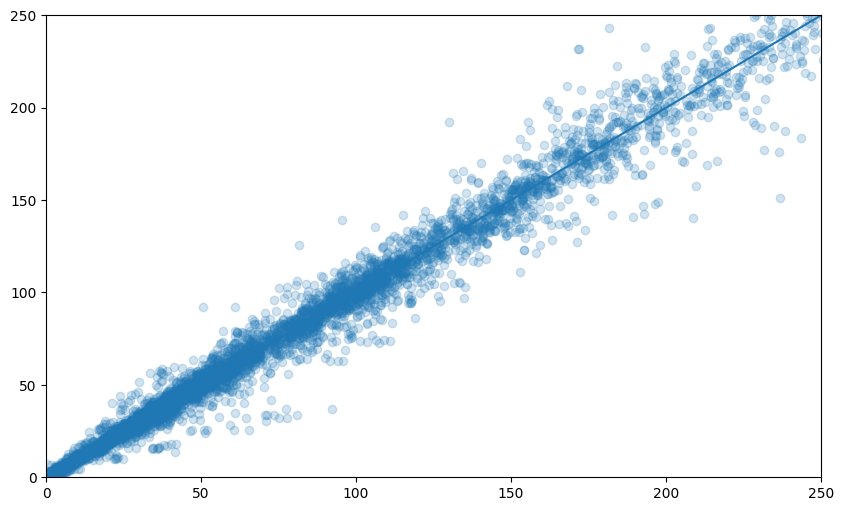

[0.00611471 0.06302513 0.4318081  0.45302993 0.01180724 0.03034343
 0.00097065 0.00135339 0.00099351 0.00055405]


In [31]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = ['emission']), df.emission, test_size = .2)
model = XGBRegressor(**xgb_params)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
se = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print('SD Error: ', se)
plt.figure(figsize = (10, 6))
plt.scatter(y_pred, y_test, alpha = .2)
plt.axline((0, 0), slope=1)
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()
print(model.feature_importances_)